## <center>Exercises 8: Variational Monte Carlo</center>

In this notebook we are going to exploit the Metropolis algorithm to sample the squared modulus of a given wave function in order to estimate the mean value of the Hamiltonian of the system, namely
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$
We are then going to use this for getting to the ground state of the system: the wave function actually depends on two paramters $\mu$ and $\sigma$ ($\Psi_T^{\sigma,\mu}(x)$) that we are going to optimize in order to find the minimum of $\langle {\hat H} \rangle_T$.
<br> In fact, the variational principle of quantum mechanics tells us that for every trial wave function (that is suitable for the Hamiltonian of the system) the mean value of the Hamiltonian is higher than the ground state of the system:
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$
Using a trial wave function that depends on some parameters, the more we optimize the parameters minimizing the mean value of the Hamiltonian the nearer we get to the ground state of the system.

<br> We are going to consider a one-dimensional system of one particle described by the trial wave function
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$
and subjected to the potential
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Exercise 1

First of all, we are going to sample the square modulus of the trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using the Metropolis algorithm. 
<br> This time every move will be chosen with a uniform transition probability: we will shift the position $x$ of a quantity $\delta$ in a random direction (backwards or forwards), regulating $\delta$ so as to have an acceptance rate of approximately $50\%$. 
<br> At fixed values of $\mu$ and $\sigma$, we are going to compute $\langle {\hat H} \rangle_T$ as the average of $M$ evaluations of 
$$E_{loc}(x)=\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$$
in the configurations $x$ sampled with the Metropolis algorithm. We will then use data blocking to give an estimation of $\langle {\hat H} \rangle_T$ and its uncertainty.

We are now going to fix $\mu$ and $\sigma$ and sample the probability $|\Psi_T^{\sigma,\mu}(x)|^2$ with the Metropolis algorithm; the acceptance rate changes depending on the values of $\mu$ and $\sigma$ and one should regulate $\delta$ every time in order to get an acceptance rate of approximately $50\%$.
<br> The simulation needs an initial phase of equilibration, which has been set to $2000$ steps. To estimate the energy we are performing data blocking with $N=100$ blocks of $1000$ steps each.

The figure below shows the results of the simulation for some fixed values of $\mu$ and $\sigma$: the first graph presents the computation of the energy as a function of the number of blocks and the second one the sampling of the probability distribution $|\Psi_T^{\sigma,\mu}(x)|^2$ compared to its exact expression; this comparison should be done just on the behaviour of the two functions, as we have never worried about normalization.

In [2]:
def psi_squared(mu, sigma, x) :
    factor = - 1.0/sigma**2
    A = np.exp(factor * (x-mu)**2)
    B = np.exp(factor * (x+mu)**2)
    C = np.exp(factor * (x**2+mu**2))
    return A + B + 2.0*C

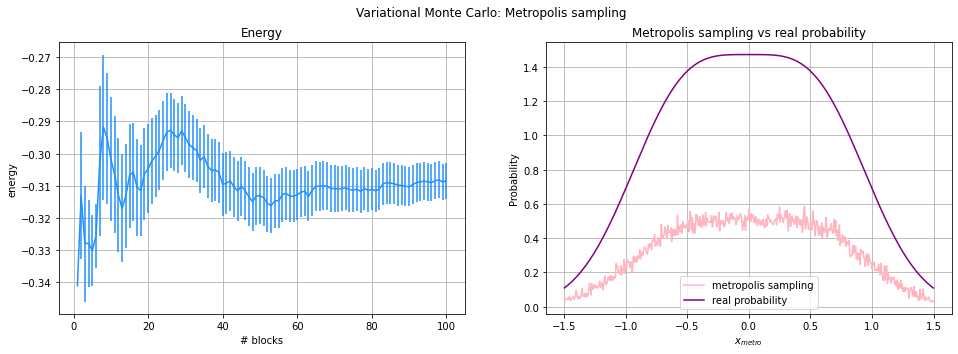

In [7]:
# loading data
nblk, ene, error = np.loadtxt("./ex_1/Output/output_energy.dat", usecols=(0,2,3), delimiter=None, unpack='true')
x, psisq = np.loadtxt("./ex_1/Output/psi_squared.dat", usecols=(0,1), delimiter=None, unpack='true')

mu = 0.6
sigma = 0.6
real_prob = psi_squared(mu,sigma,x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Variational Monte Carlo: Metropolis sampling')

ax1.errorbar(nblk,ene,yerr=error,color='dodgerblue')
ax1.set_xlabel('# blocks')
ax1.set_ylabel('energy')
ax1.set_title('Energy')
ax1.grid(True)

ax2.plot(x,psisq,color='lightpink',label='metropolis sampling')
ax2.plot(x,real_prob,color='purple',label='real probability')
ax2.set_xlabel('$x_{metro}$')
ax2.set_ylabel('Probability')
ax2.set_title('Metropolis sampling vs real probability')
ax2.legend(loc='best')
ax2.grid(True)

plt.show()

<br> Trying different values of $\mu$ and $\sigma$, with a bigger $\mu$ and a lower $\sigma$ the probability separates into two peaks: if the starting configuration is near one of the two peaks the algorithm will try to get nearer and won't go to the other one as there is an almost null plateau between the two. In this situation the algorithm gets stuck around one of the two peaks and does not sample the other one: as the problem is perfectly symmetric with respect to $x=0$, a possible solution could be taking $-x$ instead of $x$ when we accept a new configuration $x$ every $N^{*}$ Metropolis steps; in fact, in $-x$ the probability and the energy are the same, and if the algorithm has accepted $x$ it means that it would have also accepted $-x$; this way, if we get stuck around some point, we can end up on the other side of $x=0$ in order to obtain a simmetric sampling. Nevertheless, this is not necessary: again because of the symmetry of the problem, if we only sample for $x<0$ or $x>0$ this doesn't change the energy estimation.

### Exercise 2

Now we will extend the Variational Monte Carlo code to optimize the variational parameters $\mu$ and $\sigma$ via a Simulated Annealing algorithm.

<br> The Simulated Annealing algorithm is practically a simulation of the slow cooling of the system. In fact, when a liquid is cooled slowly its atoms manage to align and form a completely ordered crystal, that is the configuration of minimum energy. If we have a function $L(\mu,\sigma)$ that we want to minimize, we can think of the problem as the slow cooling of a system with energy $L(\mu,\sigma)$: following its natural evolution throughout cooling, namely sampling the Boltzmann weight $p(\mu,\sigma)=\exp(-\beta L(\mu,\sigma))/Z$ decreasing temperature every $n$ Monte Carlo steps, we will eventually reach the minimum of $L(\mu,\sigma)$. 

In our case $L(\mu,\sigma)=\langle H \rangle_{\mu,\sigma}$.
<br> Fixing some initial values of the parameters $\mu$ and $\sigma$, we are going to start from a temperature $T_{start}$ and take $n$ Monte Carlo steps, sampling the probability distribution $p(\mu,\sigma)$ at fixed temperature $T_{start}$ with the Metropolis algorithm; in this case the move will be shifting $\mu$ and $\sigma$ of the quantities $\delta_{\mu}$ and $\delta_{\sigma}$ in a random direction (backwards or forwards). At the end of these steps we will have a measure of
$\langle H \rangle_{\mu,\sigma}$ for the temperature $T_{start}$. 
<br> We are going to repeat this procedure for $n_{temp}$ values of temperature, decreasing it with a certain rate $\alpha$ after every $n$ Monte Carlo steps, so that $T_{i+1}=\alpha T_{i}$ where $i$ is the index representing each of the $n_{temp}$ temperature steps. 

The parameters I chosen for the simulation are the following:
- $\mu_{start} = 0.1$ and $\sigma_{start} = 3.0$
- $T_{start} = 4.0$, $T_{min} = $ and $\alpha=0.95$; the number of temperature steps is computed in the code once set an initial temperature, a minimum temperature we cannot go below and a decreasing rate $\alpha$
- equilibration steps: $2000$ for the computation of the energy and $10$ for moves of $\mu$ and $\sigma$ every temperature step
- $20$ blocks of $1000$ steps each for the computation of the energy and its uncertainty

The graph below shows the minimization of the energy throughout the simulation as a function of the number of temperature steps in the Simulated Annealing algorithm. As we can see from the comparison with the actual ground state energy, the estimation of the energy in the simulation converges to the exact value of the ground state energy after approximately $60$ steps in temperature. Trying different values of $\alpha$, one can state that the more the cooling is slow (so the more the decreasing rate is high) the nearer one gets to the ground state.

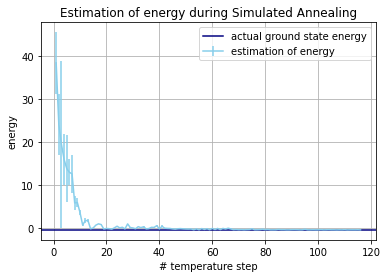

In [20]:
# energy as a function of temperature-step
ntemp, ene, error = np.loadtxt("./ex_2/Output/energy.dat", usecols=(0,2,3), delimiter=None, unpack='true')
plt.errorbar(ntemp,ene,yerr=error,color='skyblue',label='estimation of energy')
plt.axhline(y=-0.46046587969271513,color='navy',label='actual ground state energy')
plt.xlabel('# temperature step')
#plt.xlim([0, 28])
#plt.ylim([-1, 1])
plt.ylabel('energy')
plt.title('Estimation of energy during Simulated Annealing')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In the following figures we can see the evolution of the parameters $\mu$ and $\sigma$ throughout the Simulated Annealing algorithm: the values in the graphs are the final values of the parameters after the $n$ Monte Carlo steps for each temperature. We can see from the first graph that when the energy stabilizes around the ground state the parameters stabilize too: those values are their optimized values.

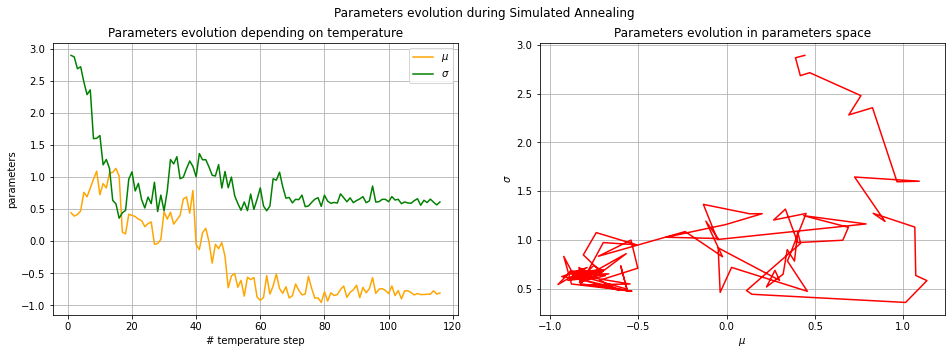

In [21]:
# loading data
ntemp, mu, sigma = np.loadtxt("./ex_2/Output/parameters.dat", usecols=(0,2,3), delimiter=None, unpack='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Parameters evolution during Simulated Annealing')

ax1.plot(ntemp,mu,color='orange',label=r'$\mu$')
ax1.plot(ntemp,sigma,color='green',label=r'$\sigma$')
ax1.set_xlabel('# temperature step')
ax1.set_ylabel('parameters')
ax1.set_title('Parameters evolution depending on temperature')
ax1.legend(loc='best')
ax1.grid(True)

ax2.plot(mu,sigma,color='red')
ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$')
ax2.set_title('Parameters evolution in parameters space')
ax2.grid()

plt.show()

In conclusion we can use the optimized $\mu$ and $\sigma$ found with the Simulated Annealing for a Variational Monte Carlo computation of the energy we have reached, as done in Exercise 1. 
<br> In the graphs below we can see a comparison between the exact solution of the ground state of the system and the ground state the simulation has found: the optimization is good, in fact the value of the energy is near that of the actual ground state and the sampled squared wave function has the same shape as the exact one, telling us that both the Simulated Annealing and the Metropolis algorithms are working well.

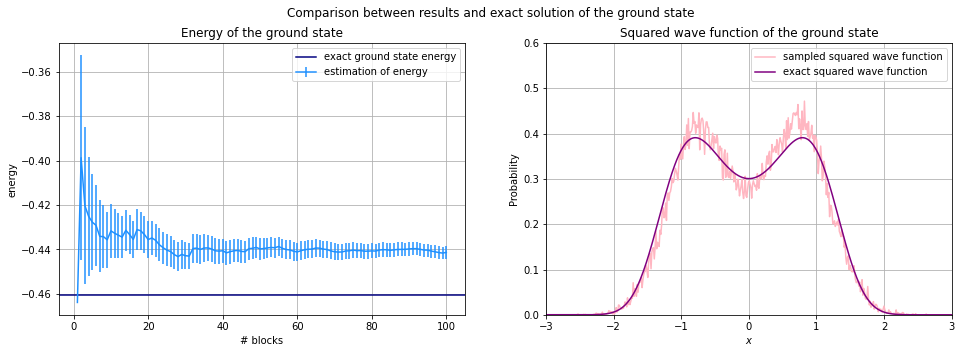

In [22]:
# computing exact results

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)


# reading my results

nblk, ene, error = np.loadtxt("./ex_2/Output/final_energy.dat", usecols=(0,2,3), delimiter=None, unpack='true')
x_sper, psisq = np.loadtxt("./ex_2/Output/psi_squared_final.dat", usecols=(0,1), delimiter=None, unpack='true')

#print("Ground state energy: ", E[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Comparison between results and exact solution of the ground state')

ax1.errorbar(nblk,ene,yerr=error,color='dodgerblue',label='estimation of energy')
ax1.axhline(y=E[0],color='navy',label='exact ground state energy')
ax1.set_xlabel('# blocks')
ax1.set_ylabel('energy')
ax1.set_title('Energy of the ground state')
ax1.legend(loc='best')
ax1.grid(True)

ax2.plot(x_sper,psisq,color='lightpink',label='sampled squared wave function')
ax2.plot(x,(psi[0])**2,color='purple',label='exact squared wave function')
ax2.set_xlabel('$x$')
ax2.set_ylabel('Probability')
ax2.set_title('Squared wave function of the ground state')
ax2.legend(loc='best')
ax2.set_xlim(-3.0,3.0)
ax2.set_ylim((0.0,0.6))
ax2.grid(True)

plt.show()